In [71]:
%run PSO.ipynb #da qui possiamousare la funzione PSO

In [72]:
import keras
import numpy as np
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical, plot_model
from keras.preprocessing.text import Tokenizer
from keras.optimizers import SGD, Adam, RMSprop
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,Flatten
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## **Dataset**
This is a collection of documents that appeared on Reuters newswire in 1987. The documents were assembled and indexed with categories. Each word is encoded with an integer.

The mean number of words per document, grouped by class, is between 93 and 1263 on the training set.


In [73]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)


In [74]:
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

8982 train sequences
2246 test sequences


In [75]:
num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

46 classes


In [76]:
print('Vectorizing sequence data...')
tokenizer = Tokenizer(num_words=10000)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Vectorizing sequence data...
x_train shape: (8982, 10000)
x_test shape: (2246, 10000)


In [77]:
print('Convert class vector to binary class matrix for use with categorical_crossentropy')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Convert class vector to binary class matrix for use with categorical_crossentropy
y_train shape: (8982, 46)
y_test shape: (2246, 46)


## **Multi-layer Perceptron**

In [78]:
from keras.callbacks import EarlyStopping

def MLP(particle_position):
    '''This function returns the accuracy of a neural network model with the parameter set as the component of the particle position.
     The first component of the position will be the batch size, the second willl be the optimizer and the third will be the learning rate. 
     particle_position[0]: batch_size
     particle_position[1]: optimizer (<1: SGD; within [1,2): SGD with Momentum; within [2,3): Adam; within [3,inf]: RMSPROP )
     particle_position[2]: learning_rate'''
    
    batch_s = particle_position[0]
    batch_s = int(batch_s)
    optimiz = particle_position[1]
    lr = particle_position[2]
    num_neuron = particle_position[3]
    
    model = Sequential()
    model.add(Dense(int(num_neuron), input_shape=(10000,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    early_stopping = EarlyStopping(monitor='val_accuracy', min_delta = 0.001, patience=3, verbose=0, mode='max', baseline=0.97)
    callbacks = [early_stopping]

    if optimiz < 1:
        #use SGD
        opt = SGD(learning_rate = lr)
        
    elif optimiz >=1 and optimiz < 2:
        #use SGD with Momentum
        opt = SGD(momentum = 0.9, learning_rate = lr)

    elif optimiz >= 2 and optimiz < 3:
        #use ADAM
        opt = Adam(learning_rate = lr)

    else:
        #use RMSPROP
        opt = RMSprop(learning_rate = lr)

    model.compile(optimizer= opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=batch_s,
                    validation_split=0.2,
                    callbacks=callbacks, 
                    verbose = 0)
    
    last_accuracy = history.history['val_accuracy'][-1]

    return last_accuracy

We use a swarm with 10 particles of dimension 4. The first dimension is the batch size, the seocnd is the type of optimizer (it can be 4 possible type), the third dimension is the learning rate and the fourth dimension is the number of neurons for the inner layer.

In [79]:
best_positions, evaluation, best_parameter, best_accuracy = PSO(swarm_size = 10,
                                    dim = 4,
                                    evaluation_funct = MLP,
                                    lower_bound=[10,0,0.001, 90],
                                    upper_bound = [128,4,0.1, 600],
                                    v_max = [64,2,0.001, 200],
                                    problem = 'maximum',
                                    max_iteration = 10,
                                    termination_criteria = ['fixed_iteration', 'swarm_radius'],
                                    max_tol = 0.1)

print('Best position found: ', best_parameter, 'with an accuracy of: ',best_accuracy)

Particle position:  [array([5.42966500e+01, 2.48429718e+00, 3.33831532e-02, 3.78413666e+02]), array([3.18242024e+01, 2.62873259e+00, 5.00943810e-02, 4.64377625e+02]), array([2.33250048e+01, 1.26905645e+00, 9.41141113e-03, 4.83439593e+02]), array([8.31362834e+01, 3.54270622e+00, 2.83504250e-02, 3.68204784e+02]), array([4.96154842e+01, 2.14843405e+00, 6.33929871e-02, 5.79671764e+02]), array([1.73191480e+01, 2.84447299e+00, 4.90601542e-03, 5.66756242e+02]), array([5.93857000e+01, 1.57693827e+00, 4.79046284e-02, 9.24872085e+01]), array([1.21920290e+02, 1.70659961e+00, 9.32428343e-02, 2.99618301e+02]), array([5.03808696e+01, 1.85277735e+00, 7.70111020e-02, 3.86610215e+02]), array([9.40185622e+01, 3.27166619e+00, 5.94132971e-02, 1.36654731e+02])]
Starting swarm position:  [array([5.42966500e+01, 2.48429718e+00, 3.33831532e-02, 3.78413666e+02]), array([3.18242024e+01, 2.62873259e+00, 5.00943810e-02, 4.64377625e+02]), array([2.33250048e+01, 1.26905645e+00, 9.41141113e-03, 4.83439593e+02]), arr

ValueError: not enough values to unpack (expected 4, got 3)

In [80]:
evaluation

[0.815247654914856,
 0.815247654914856,
 0.815247654914856,
 0.815804123878479,
 0.816360592842102,
 0.816360592842102,
 0.8202559947967529,
 0.8202559947967529,
 0.8202559947967529,
 0.8202559947967529,
 0.8202559947967529]

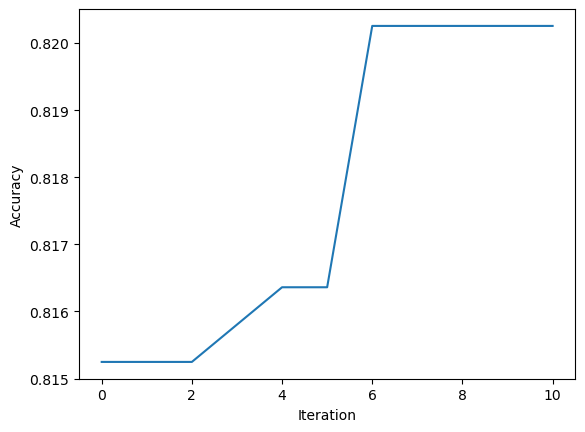

In [81]:
# Let's plot the best evaluation function (in this case the best accuracy) found for each iteration.
plt.plot(list(range(len(evaluation))), evaluation)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()

In [68]:
batch_size = [iter[0] for iter in best_positions]
optimizer = [iter[1] for iter in best_positions]
learning_rate = [iter[2] for iter in best_positions]
num_neuron = [iter[3] for iter in best_positions]




NameError: name 'best_positions' is not defined